###Title: Making the Rain
###Authors:
    Bryan Zanoli
    Daniel Arias
    Kyle Stefun
    Victor Gomez
###Intro: 


###Description of source data set:
Data set includes all historical annual percipitation data for California's rain stations by year. Each annual entry includes data related to the Station
name and station location by county as well as direct latitude and longitudinal coordinates. 
###What will be predicted:
We will build out a predictive model that will forecast the next several annual rainfall totals, by station. 
In addition we will create a model that will determine the predictive power of using kNN to predict rainfall for nearby stations. This model
can then be used to determine if fewer stations can be leveraged to glean similar rainfall estimation capabilities.
###What features will be used as predictors: 
TotalPrecipitation
WaterYear
StationName
County
x_coord and y_coord directly correspond to the StationName

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import random as random
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

In [68]:
df = pd.read_csv(r"C:\Users\zanol\OneDrive\Documents\School\CSUMB\CST383-30\project\lwu-precip-data-to-2023_basic_flatfile_withcoordinates.csv", index_col=None)
df.columns = df.columns.str.strip()
df.info()

df = df.dropna(subset = ['TotalPrecipitation_inches', 'WaterYear'])
nonfloat = np.where(df['TotalPrecipitation_inches'] == '.')[0]
df.drop(df.index[nonfloat], inplace=True)

df['TotalPrecipitation_inches'] = df['TotalPrecipitation_inches'].astype('float64')

df.info()

#df['TotalPrecipitation_inches'] = df['TotalPrecipitation_inches'].astype('float64')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StationName                2152 non-null   object 
 1   County                     2152 non-null   object 
 2   BeginGageServiceDate       1868 non-null   object 
 3   EndGageServiceDate         1874 non-null   object 
 4   TotalPrecipitation_inches  2085 non-null   object 
 5   WaterYear                  2152 non-null   int64  
 6   Notes_FlaggedResults       416 non-null    object 
 7   x_coord                    2152 non-null   float64
 8   y_coord                    2152 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 151.4+ KB
StationName                  False
County                       False
BeginGageServiceDate          True
EndGageServiceDate            True
TotalPrecipitation_inches    False
WaterYear                    False
Note

In [24]:
df.head(20)

,StationName,County,BeginGageServiceDate,EndGageServiceDate,TotalPrecipitation_inches,WaterYear,Notes_FlaggedResults,x_coord,y_coord
0,Ball Mountain,Tehama,9/26/1950,6/7/1951,39.51,1951,NaN,-122.780911,39.936369
1,Ball Mountain,Tehama,6/7/1951,9/10/1952,42.65,1952,NaN,-122.780911,39.936369
2,Ball Mountain,Tehama,9/10/1952,7/23/1953,44.09,1953,NaN,-122.780911,39.936369
3,Ball Mountain,Tehama,7/23/1953,7/13/1954,41.92,1954,NaN,-122.780911,39.936369
4,Ball Mountain,Tehama,7/13/1954,7/28/1955,28.42,1955,NaN,-122.780911,39.936369
5,Ball Mountain,Tehama,7/28/1955,7/23/1956,58.65,1956,NaN,-122.780911,39.936369
6,Ball Mountain,Tehama,7/23/1956,7/30/1957,30.18,1957,NaN,-122.780911,39.936369
7,Ball Mountain,Tehama,7/30/1957,7/8/1958,64.40,1958,NaN,-122.780911,39.936369
8,Ball Mountain,Tehama,7/8/1958,7/8/1959,29.02,1959,NaN,-122.780911,39.936369
9,Ball Mountain,Tehama,7/8/1959,7/20/1960,37.00,1960,NaN,-122.780911,39.936369


In [27]:
df.groupby(['StationName'])['TotalPrecipitation_inches'].sum()

StationName
Ball Mountain         2724.01
Blacks Mountain       1843.10
Boulder Creek         1275.23
Butte Lake            1921.61
Camel Peak            3393.05
Champs Flat           1170.03
Clarks Peak           1411.07
Clover Valley         1160.55
Crowder Flat          1170.14
Dewitt Peak           1607.84
Dodge Reservoir        846.91
Gazelle Mountain      1158.59
Granite Springs        935.69
Hogsback Road         1648.85
Lassen Creek          1703.64
Lights Creek          2011.87
Little Last Chance    1092.05
Long Bell Station     1797.40
McCarthy Point        3303.77
Medicine Lake         3143.49
Mount Hough           2809.75
Mount Shasta          4870.72
Mumbo Basin           4417.45
Onion Valley          3661.82
Patterson Meadow      1782.03
Pepperdine Camp       1789.05
Plaskett Meadow       3801.03
Saddle Camp           2262.46
Shaffer Mountain       490.56
Stouts Meadow         6500.59
Swain Mountain        2562.36
Sweagert Flat         1903.99
Three Mile Valley     2228.2

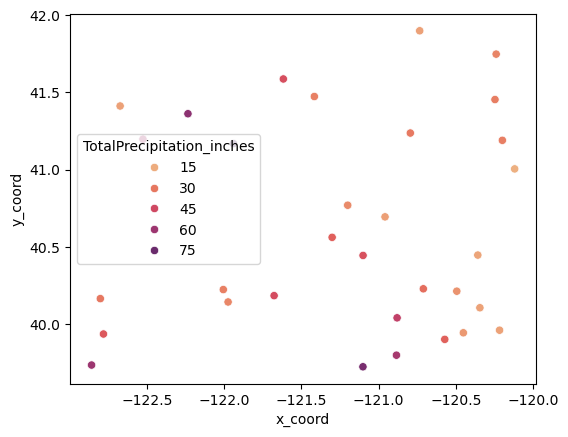

In [91]:
stations = df.groupby('StationName').agg({'TotalPrecipitation_inches': 'mean', 'x_coord': 'first', 'y_coord': 'first'})

sns.scatterplot(stations, x='x_coord', y='y_coord', hue='TotalPrecipitation_inches', palette='flare')
plt.show()

In [41]:
#Continue at 1707 (Could not download 824)
df_coord = df[['x_coord', 'y_coord']].drop_duplicates()
print(df_coord)

         x_coord    y_coord
0    -122.780911  39.936369
73   -121.199842  40.770035
203  -121.300571  40.562129
266  -121.101150  39.724185
322  -120.958127  40.694720
387  -120.493576  40.213588
452  -120.451123  39.944236
510  -120.733770  41.899319
574  -121.974141  40.143699
637  -120.118943  41.005192
702  -122.673088  41.412434
769  -120.344061  40.106337
824  -122.005063  40.223982
887  -120.238747  41.748293
952  -120.710175  40.229006
1016 -120.216747  39.961030
1080 -121.415662  41.473765
1145 -121.676234  40.184694
1224 -121.616421  41.587380
1301 -120.880075  40.041047
1360 -122.233988  41.362290
1436 -122.525250  41.197907
1513 -120.884227  39.799262
1577 -120.198529  41.190193
1642 -120.246323  41.454164
1707 -122.857873  39.735429
1770 -122.801191  40.165379
1848 -120.357534  40.447365
1881 -121.939585  41.168906
1958 -121.100349  40.444958
2023 -120.794337  41.237361
2088 -120.571455  39.901697


In [84]:
### Machine Learning Preliminary Work
def rmse(predicted, actual):
    return np.sqrt(((predicted - actual)**2).mean())

#Average Percipitation
X = df[['WaterYear']]
y = df['TotalPrecipitation_inches']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

regr = LinearRegression()
regr.fit(X_train,y_train)
predicted = regr.predict(X_test)

print('AVERAGE ACROSS ALL STATIONS')
print('RMSE: {}'.format(rmse(predicted, y_test)))
print('R2: {}'.format(regr.score(X_train, y_train)))

#Percipitation per Station
for station in df['StationName'].unique():
    X = df[df['StationName'] == station][['WaterYear']]
    y = df[df['StationName'] == station]['TotalPrecipitation_inches']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
    
    regr = LinearRegression()
    regr.fit(X_train,y_train)
    predicted = regr.predict(X_test)

    print('STATION: {}'.format(station))
    print('RMSE: {}'.format(rmse(predicted, y_test)))
    print('R2: {}'.format(regr.score(X_train, y_train)))

#knn to predict precipitation output based on coordinates
#linear_regression for water precipitation over time

predictors = ['TotalPrecipitation_inches']['WaterYear']
X = df['predictors']
y = df['StationName']

AVERAGE ACROSS ALL STATIONS
RMSE: 23.277680086395144
R2: 0.009702828519034812
STATION: Ball Mountain
RMSE: 21.47153153534016
R2: 0.10121237158822327
STATION: Blacks Mountain
RMSE: 7.839346084492648
R2: 0.0010583606455543126
STATION: Boulder Creek
RMSE: 10.112481877671865
R2: 0.0021324403663307567
STATION: Butte Lake
RMSE: 13.753217336188884
R2: 0.03629087176843848
STATION: Camel Peak
RMSE: 22.044483936257173
R2: 0.010334874067361999
STATION: Champs Flat
RMSE: 6.828209724413158
R2: 0.020274399517969166
STATION: Clarks Peak
RMSE: 7.285907602842022
R2: 0.00044907692659201803
STATION: Clover Valley
RMSE: 7.93949192523439
R2: 0.007474714682054628
STATION: Crowder Flat
RMSE: 4.551829903172636
R2: 0.0034512216729742917
STATION: Dewitt Peak
RMSE: 10.665191386983224
R2: 0.0032216889381591063
STATION: Dodge Reservoir
RMSE: 4.334295721215651
R2: 0.06446909616260388
STATION: Gazelle Mountain
RMSE: 4.388919308827848
R2: 0.018831673949570416
STATION: Granite Springs
RMSE: 7.037254371843705
R2: 0.039